In [1]:
!date

Wed Aug 14 12:20:36 PDT 2024


In [2]:
%load_ext autoreload
%load_ext line_profiler

In [3]:
import logging

logging.basicConfig(level=logging.INFO, force=True)

In [4]:
import os as _os

_os.chdir(_os.environ["PROJECT_ROOT"])

In [5]:
import os
from contextlib import contextmanager
from itertools import chain, product
from multiprocessing import Pool

import fastcluster
import graph_tool as gt
import graph_tool.draw
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import strainzip as sz
import strainzip.app.unzip
import xarray as xr
from graph_tool.util import find_edge
from scipy.cluster.hierarchy import fcluster, linkage
from strainzip.pandas_util import idxwhere
from tqdm import tqdm

import lib.plot

In [6]:
mpl.rcParams["figure.dpi"] = 100
# sns.set_context('talk')

In [7]:
# Plotting parameters

length_bins = np.logspace(0, 6.5, num=51)
depth_bins = np.logspace(-1, 4, num=51)

draw_graphs = True

In [8]:
k = 111
group = "xjin_test2"
graph_type = f"k{k}-withmegahit2-droptips"
deconv = "norm-10-10"
# kmtricks = 'k111-m3-r2'
clust_params = "e50-d20"

fig_dir = (
    f"fig/group/{group}/r.proc.ggcat-{graph_type}.notips-2.smoothed-6.unzip-{deconv}.d"
)
if not os.path.exists(fig_dir):
    print(f"mkdir -p {fig_dir}")

In [9]:
# Metadata
sample_idx_to_id = (
    pd.read_table("meta/mgen_group.tsv", names=["mgen_id", "mgen_group"])[
        lambda x: x.mgen_group == group
    ]
    .mgen_id.to_frame()
    .assign(idx=lambda x: range(len(x)))
    .set_index("idx")
    .mgen_id
)
sample_idx_to_id

# NOTE: This only applies to xjin samples:
# sample_idx_to_id = sample_idx_to_id.str.split('_', n=1).str[1]
sample_idx_to_id  # .head()

idx
0              xjin_N_P5R2b
1              xjin_N_P5R2c
2              xjin_N_P5R3a
3              xjin_N_P5R3b
4              xjin_N_P5R3c
5    xjin_XT_Innoculum_Rep1
6    xjin_XT_Innoculum_Rep2
Name: mgen_id, dtype: object

In [10]:
clust_meta = pd.read_table(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.smoothed-6.unzip-{deconv}.clust-{clust_params}.meta.tsv",
    index_col="cluster",
)
vertex_to_clust = pd.read_table(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.smoothed-6.unzip-{deconv}.clust-{clust_params}.vertex.tsv",
    index_col="vertex",
).cluster
segement_x_clust = pd.read_table(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.smoothed-6.unzip-{deconv}.clust-{clust_params}.segment.tsv",
    index_col="segment",
).cluster
print(len(clust_meta))
clust_meta.sort_values("total_length", ascending=False).head(5)

1355


,num_vertices,num_segments,num_unique_segments,total_length,total_depth
cluster,,,,,
1113,91398,118440,110504,209857585,1.678029
360,2382,28991,24906,49697156,44.040000
164,2076,40957,37421,41118591,19.668717
473,908,10510,9263,28018251,6.825675
300,2951,41833,38409,22054751,60.627384


In [11]:
%%time

unpressed_graph = sz.io.load_graph(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2-unpressed.sz"
)
unpressed_results = sz.results.extract_vertex_data(unpressed_graph)
print(
    (unpressed_results.length * unpressed_results.total_depth).sum()
    / unpressed_results.total_depth.sum()
)

obs_segment_depth = sz.results.extract_segment_depth(unpressed_graph)

197.03200597344906
CPU times: user 8.95 s, sys: 365 ms, total: 9.31 s
Wall time: 9.34 s


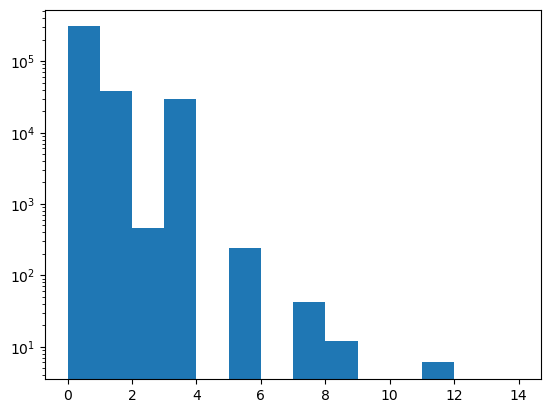

In [12]:
segment_length = (
    unpressed_results.assign(segment=lambda x: x.segments.str[0])
    .set_index("segment")
    .length
)
# For each segment how many extra paths could have gone through it? max((N * M) - 1, 0)
segment_complexity = pd.Series(
    (unpressed_results.num_in_neighbors * unpressed_results.num_out_neighbors - 1)
    .where(lambda x: x > 0, 0)
    .values,
    index=unpressed_results.segments.str[0],
)
squared_segment_complexity = np.square(segment_complexity)

plt.hist(segment_complexity, bins=np.arange(15))
plt.yscale("log")

In [13]:
%%time
final_graph = sz.io.load_graph(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.smoothed-6.unzip-{deconv}.sz"
)
final_results = sz.results.extract_vertex_data(final_graph)
ss_vertex_complexity = (
    final_results.segments.explode()
    .to_frame("segment")
    .reset_index()
    .join(squared_segment_complexity.rename("segment_complexity"), on="segment")
    .drop_duplicates()
    .groupby("vertex")
    .segment_complexity.sum()
)
vertex_complexity = np.sqrt(ss_vertex_complexity)

final_results = final_results.assign(
    complexity=vertex_complexity,
    clust=vertex_to_clust.reindex(final_results.index, fill_value=-1),
)

vertex_depth = sz.results.depth_table(final_graph, final_graph.get_vertices()).T
vertex_length = pd.Series(final_graph.vp["length"], index=final_graph.get_vertices())

CPU times: user 3.64 s, sys: 70 ms, total: 3.71 s
Wall time: 3.74 s


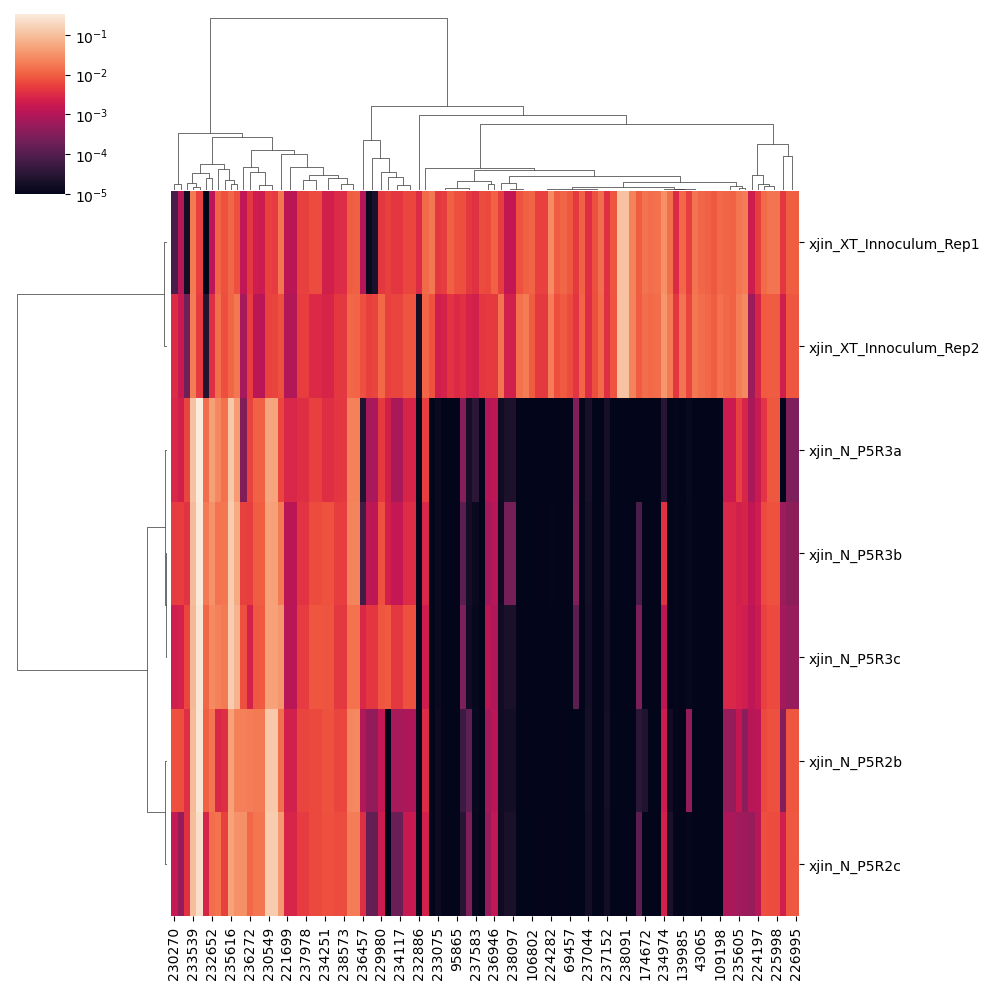

In [14]:
# Normalize by rpoB and gyrA depth

marker_model = "TIGR02013"

marker_genes = pd.read_table(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.smoothed-6.unzip-{deconv}.cds.tran.hmmer-{marker_model}-ga.tsv",
    names=["orf", "gene_name", "bitscore"],
).assign(vertex=lambda x: x.orf.str.split("_").str[0].astype(int))
_marker_gene_vertex_list = list(set(marker_genes.vertex))
marker_depth = vertex_depth.loc[_marker_gene_vertex_list].T
total_marker_depth = marker_depth.sum(1)

normalized_vertex_depth = vertex_depth.divide(total_marker_depth)

marker_rabund = marker_depth.divide(total_marker_depth, axis=0)
# plt.hist(marker_depth.sum())
sns.clustermap(
    marker_rabund.rename(sample_idx_to_id) + 1e-5,
    norm=mpl.colors.SymLogNorm(1e-5),
    metric="cosine",
)

In [15]:
%%time

print(
    (final_results.length * final_results.total_depth).sum()
    / final_results.total_depth.sum()
)
final_segment_depth = sz.results.extract_segment_depth(final_graph)

987.3164026350904
CPU times: user 3.01 s, sys: 159 ms, total: 3.17 s
Wall time: 3.2 s


In [16]:
# Used below for visualizing the graph
# This part is slow enough that it's better to cache it and pass it to the get_shortest_distance function.
backlinked_unpressed_graph = sz.topology.backlinked_graph(unpressed_graph)

PearsonRResult(statistic=0.9993038964694172, pvalue=0.0)
CPU times: user 259 ms, sys: 1.74 ms, total: 261 ms
Wall time: 260 ms


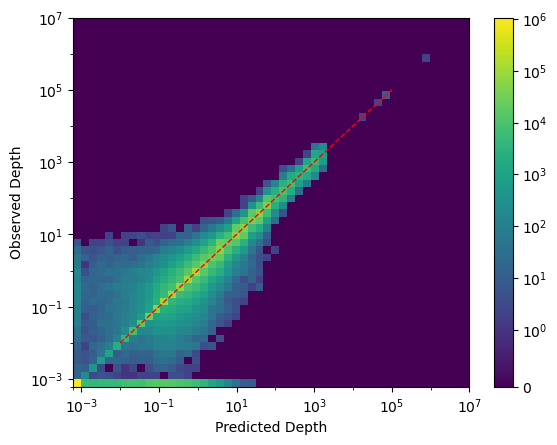

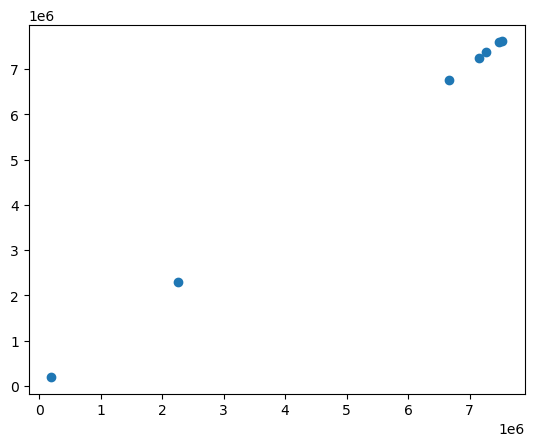

In [17]:
%%time

y, x = obs_segment_depth.align(final_segment_depth, join="left")

bins = np.concatenate([[0], np.logspace(-3, 7, num=50)])

fig = plt.figure()
plt.hist2d(
    x.values.ravel(),
    y.values.ravel(),
    bins=bins,
    norm=mpl.colors.SymLogNorm(linthresh=1),
)
plt.xscale("symlog", linthresh=1e-3, linscale=0.2)
plt.yscale("symlog", linthresh=1e-3, linscale=0.2)
plt.plot([1e-2, 1e5], [1e-2, 1e5], lw=1, linestyle="--", color="r")
plt.colorbar()
plt.xticks(np.logspace(-3, 7, num=6))
plt.yticks(np.logspace(-3, 7, num=6))
plt.xlabel("Predicted Depth")
plt.ylabel("Observed Depth")

print(sp.stats.pearsonr(x.values.ravel(), y.values.ravel()))

fig = plt.figure()
plt.scatter(x.sum(), y.sum())

In [18]:
sp.stats.pearsonr(x.values.ravel(), y.values.ravel()).statistic ** 2

0.9986082774989596

In [19]:
notips_graph = sz.io.load_graph(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.smoothed-6.sz"
)
notips_results = sz.results.extract_vertex_data(notips_graph)
sz.stats.depth_weighted_mean_tig_length(notips_graph)

PropertyArray(251.12702084)

In [20]:
notips_unsmoothed_graph = sz.io.load_graph(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.sz"
)
notips_unsmoothed_results = sz.results.extract_vertex_data(notips_unsmoothed_graph)
sz.stats.depth_weighted_mean_tig_length(notips_unsmoothed_graph)

PropertyArray(250.53750624)

PearsonRResult(statistic=0.9991186587167238, pvalue=0.0)

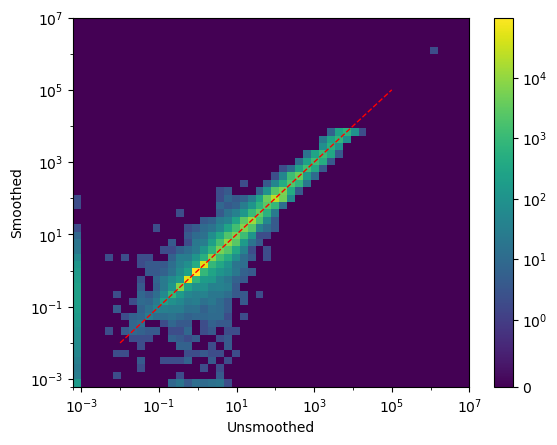

In [21]:
y, x = notips_results.total_depth.align(notips_unsmoothed_results.total_depth)

bins = np.concatenate([[0], np.logspace(-3, 7, num=50)])

fig = plt.figure()
plt.hist2d(x, y, bins=bins, norm=mpl.colors.SymLogNorm(linthresh=1))
plt.xscale("symlog", linthresh=1e-3, linscale=0.2)
plt.yscale("symlog", linthresh=1e-3, linscale=0.2)
plt.plot([1e-2, 1e5], [1e-2, 1e5], lw=1, linestyle="--", color="r")
plt.colorbar()
plt.xticks(np.logspace(-3, 7, num=6))
plt.yticks(np.logspace(-3, 7, num=6))
plt.xlabel("Unsmoothed")
plt.ylabel("Smoothed")

sp.stats.pearsonr(x, y)

In [22]:
round0_graph = sz.io.load_graph(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.smoothed-6.unzip-{deconv}.checkpoints.d/checkpoint_0.sz"
)
round0_results = sz.results.extract_vertex_data(round0_graph)
print(sz.stats.depth_weighted_mean_tig_length(round0_graph))

# round1_graph = sz.io.load_graph(f'data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.smoothed-6.unzip-{deconv}.checkpoints.d/checkpoint_1.sz')
# round1_results = sz.results.extract_vertex_data(round1_graph)
# # print(sz.stats.depth_weighted_mean_tig_length(round1_graph))

round2_graph = sz.io.load_graph(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.smoothed-6.unzip-{deconv}.checkpoints.d/checkpoint_2.sz"
)
round2_results = sz.results.extract_vertex_data(round2_graph)
print(sz.stats.depth_weighted_mean_tig_length(round2_graph))

# round3_graph = sz.io.load_graph(f'data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.smoothed-6.unzip-{deconv}.checkpoints.d/checkpoint_3.sz')
# round3_results = sz.results.extract_vertex_data(round3_graph)
# # print(sz.stats.depth_weighted_mean_tig_length(round3_graph))

# round4_graph = sz.io.load_graph(f'data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.smoothed-6.unzip-{deconv}.checkpoints.d/checkpoint_4.sz')
# round4_results = sz.results.extract_vertex_data(round4_graph)
# # print(sz.stats.depth_weighted_mean_tig_length(round4_graph))

# round5_graph = sz.io.load_graph(f'data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.smoothed-6.unzip-{deconv}.checkpoints.d/checkpoint_5.sz')
# round5_results = sz.results.extract_vertex_data(round5_graph)
# # print(sz.stats.depth_weighted_mean_tig_length(round5_graph))

# round6_graph = sz.io.load_graph(f'data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.smoothed-6.unzip-{deconv}.checkpoints.d/checkpoint_6.sz')
# round6_results = sz.results.extract_vertex_data(round6_graph)
# # print(sz.stats.depth_weighted_mean_tig_length(round6_graph))

round7_graph = sz.io.load_graph(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.smoothed-6.unzip-{deconv}.checkpoints.d/checkpoint_7.sz"
)
round7_results = sz.results.extract_vertex_data(round7_graph)
print(sz.stats.depth_weighted_mean_tig_length(round7_graph))

# round8_graph = sz.io.load_graph(f'data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.smoothed-6.unzip-{deconv}.checkpoints.d/checkpoint_8.sz')
# round8_results = sz.results.extract_vertex_data(round8_graph)
# # print(sz.stats.depth_weighted_mean_tig_length(round8_graph))

# round9_graph = sz.io.load_graph(f'data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.smoothed-6.unzip-{deconv}.checkpoints.d/checkpoint_9.sz')
# round9_results = sz.results.extract_vertex_data(round9_graph)
# # print(sz.stats.depth_weighted_mean_tig_length(round9_graph))

256.068268980576
569.0311885389003
922.8527256088678


In [79]:
k77_graph = sz.io.load_graph(
    f"data/group/{group}/r.proc.ggcat-k77-withmegahit2-droptips.notips-2.smoothed-6.unzip-{deconv}.sz"
)
k77_results = sz.results.extract_vertex_data(k77_graph)
print(sz.stats.depth_weighted_mean_tig_length(k77_graph))

181.6892358258781


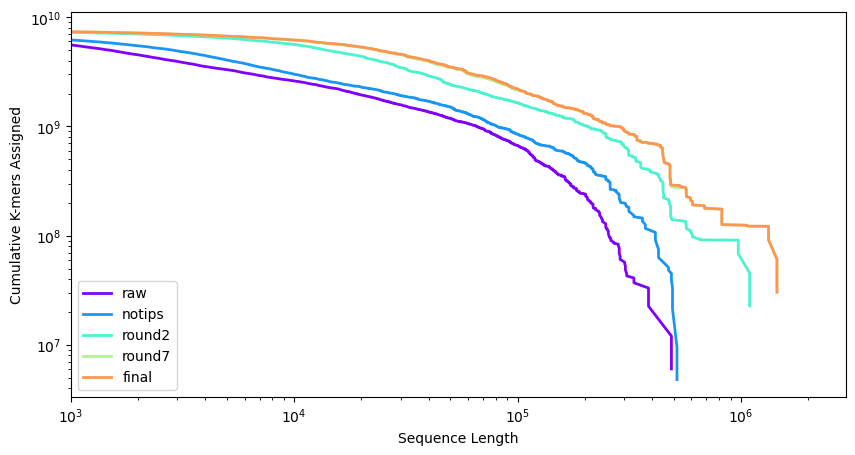

In [23]:
# Overall, we get about 2x as much long sequence depth (distribution of tig lengths of assigned kmers)
fig, ax = plt.subplots(figsize=(10, 5))

_results_mapping = {
    "raw": unpressed_results,
    # 'notips-unsmoothed': unsmoothed_results,
    "notips": notips_results,
    # 'safeonly': safeonly_results,
    # 'round1': round1_results,
    "round2": round2_results,
    # 'round3': round3_results,
    # 'round4': round4_results,
    "round7": round7_results,
    # 'unsmoothed': unsmoothed_results,
    # 'round15': round15_results,
    # 'round25': round25_results,
    "final": final_results,
    # 'norefs': norefs_results,
    # 'alt1': alt1_results,
    # 'alt3': alt3_results,
    # 'alt4': alt4_results,
    # 'alt5': alt5_results,
}

_cmap = lib.plot.construct_ordered_palette(_results_mapping.keys(), cm="rainbow")


for _label in _results_mapping:
    _results = _results_mapping[_label]
    _c = _cmap[_label]
    d = _results.sort_values("length", ascending=False).assign(
        length_x_depth=lambda x: x.total_depth * x.length,
        length_x_depth_cumsum=lambda x: x.length_x_depth.cumsum(),
    )
    ax.plot("length", "length_x_depth_cumsum", data=d, label=_label, color=_c, lw=2)

ax.set_xlabel("Sequence Length")
ax.set_ylabel("Cumulative K-mers Assigned")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(left=1e3)
# ax.set_ylim(1e9, 4e10)

ax.legend(loc="lower left")  # bbox_to_anchor=(1, 1))
# ax.invert_xaxis()

In [80]:
_results_mapping = {
    "cdBG": unpressed_results,
    "Trim Tips": notips_results,
    "Drop Low Depth": round0_results,
    # 'Round 1': round1_results,
    "Round 2": round2_results,
    # 'Round 3': round3_results,
    # 'Round 4': round4_results,
    # 'Round 5': round5_results,
    # 'Round 6': round6_results,
    "Round 7": round7_results,
    # 'Round 8': round8_results,
    # 'Round 9': round9_results,
    "Round 10": final_results,
    "k=77": k77_results,
}

In [81]:
depth_weighted_median_tig_length_data = {"Kmer": 1}
for round_name in _results_mapping:
    d0 = (
        _results_mapping[round_name]
        .assign(total_kmers=lambda x: x.length * x.total_depth)
        .sort_values("length", ascending=False)
    )
    median_vertex = ((d0.total_kmers.cumsum() / d0.total_kmers.sum()) > 0.5).idxmax()
    depth_weighted_median_tig_length_data[round_name] = d0.loc[median_vertex].length
    print(f"{round_name}: {depth_weighted_median_tig_length_data[round_name]}")

depth_weighted_median_tig_length_data = pd.Series(depth_weighted_median_tig_length_data)

cdBG: 3184
Trim Tips: 5691
Drop Low Depth: 5882
Round 2: 25686
Round 7: 40887
Round 10: 42556
k=77: 2539


/pollard/data/projects/bsmith/strain-aware-assembly/lib/plot.py:493: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


(-0.35000000000000003, 14.0)

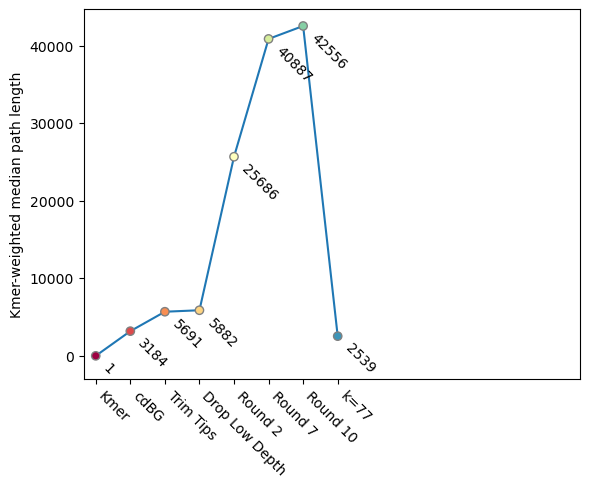

In [82]:
_color_palette = lib.plot.construct_ordered_palette(
    depth_weighted_median_tig_length_data.keys()
)
plt.plot(depth_weighted_median_tig_length_data)
plt.scatter(
    range(len(depth_weighted_median_tig_length_data)),
    depth_weighted_median_tig_length_data.values,
    c=depth_weighted_median_tig_length_data.index.to_series().map(_color_palette),
    edgecolor="grey",
    zorder=2,
)
for x, (_label, y) in enumerate(depth_weighted_median_tig_length_data.items()):
    plt.annotate(
        y,
        xy=(x, y),
        rotation=-45,
        ha="left",
        va="top",
        xytext=(5, -5),
        textcoords="offset pixels",
    )
lib.plot.rotate_xticklabels(rotation=-45, ha="left", va="top")
plt.ylabel("Kmer-weighted median path length")
plt.ylim(bottom=-3000)
plt.xlim(right=14)

In [86]:
k77_results.sort_values('num_segments', ascending=False).head(50)

,in_neighbors,out_neighbors,length,total_depth,segments,num_segments,num_in_neighbors,num_out_neighbors
vertex,,,,,,,,
488842,(434854),(434595),142068,2.448594,"(765727-, 230029+, 651957-, 298076-, 630527-, ...",542,1,1
486347,(434854),(434595),142068,2.448720,"(765727-, 230029+, 651957-, 298076-, 630527-, ...",542,1,1
522111,(45961),(),187471,2.452990,"(34376-, 684533-, 684202+, 542089-, 317472-, 7...",516,1,0
503140,(345843),(349734),149347,3.562116,"(41296-, 41298-, 304062+, 548761-, 438872-, 69...",437,1,1
503385,(345843),(349734),149347,29.238091,"(41296-, 41298-, 304062+, 548761-, 438872-, 69...",437,1,1
522940,(),(30514),165809,2.333767,"(412107+, 678525+, 566667-, 567003+, 464449-, ...",434,0,1
517641,(477054),"(444809, 443669)",117320,1.374755,"(451511+, 451322+, 357664+, 489026+, 722768+, ...",402,1,2
488300,(463603),(349287),139643,29.404473,"(298677+, 151858+, 623521+, 47442-, 341522+, 3...",399,1,1
486601,(463603),(349287),139643,3.629939,"(298677+, 151858+, 623521+, 47442-, 341522+, 3...",399,1,1


In [30]:
# Load annotations

prophage_positions = pd.read_table(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.smoothed-6.unzip-{deconv}.genomad.d/contigs_summary/contigs_virus_summary.tsv"
)
prophage_positions = prophage_positions[lambda x: x.topology.isin(["Provirus"])].assign(
    vertex=lambda d: d.seq_name.str.split("_").str[0].str.split("|").str[0].astype(int),
    left=lambda d: d.coordinates.str.split("-").str[0].astype(int),
    right=lambda d: d.coordinates.str.split("-").str[1].astype(int),
)

In [31]:
# Compile segments in vertices
segment_positions = sz.results.vertex_segment_positions(
    final_results, segment_length, final_graph.gp["kmer_length"]
)

In [32]:
# Load annotations

amr_positions = pd.read_table(
    f"data/group/{group}/r.proc.ggcat-{graph_type}.notips-2.smoothed-6.unzip-{deconv}.resfinder.d/ResFinder_results_tab.txt"
)
amr_positions = amr_positions.assign(
    vertex=lambda d: d["Contig"].str.split("_").str[0].astype(int),
    left=lambda d: d["Position in contig"].str.split(".").str[0].astype(int),
    right=lambda d: d["Position in contig"].str.split(".").str[-1].astype(int),
)

In [33]:
# Prophage with an encoded AMR gene.
pd.merge(
    amr_positions,
    prophage_positions,
    how="inner",
    on="vertex",
    suffixes=["_amr", "_prophage"],
)

,Resistance gene,Identity,Alignment Length/Gene Length,Coverage,Position in reference,Contig,Position in contig,Phenotype,Accession no.,vertex,...,coordinates,n_genes,genetic_code,virus_score,fdr,n_hallmarks,marker_enrichment,taxonomy,left_prophage,right_prophage
0,blaACI-1,100.0,855/855,100.0,1..855,238595_238611,17266..18120,"Amoxicillin, Ampicillin, Ticarcillin, Ceftazid...",AJ007350,238595,...,11267-59405,58,11,0.9510,NaN,18,70.0758,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...,11267,59405
1,blaACI-1,100.0,855/855,100.0,1..855,226662_226374,41287..42141,"Amoxicillin, Ampicillin, Ticarcillin, Ceftazid...",AJ007350,226662,...,2-48140,59,11,0.9479,NaN,18,70.1920,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...,2,48140
2,blaACI-1,100.0,855/855,100.0,1..855,237948_237916,41287..42141,"Amoxicillin, Ampicillin, Ticarcillin, Ceftazid...",AJ007350,237948,...,2-48140,58,11,0.9493,NaN,18,70.0758,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...,2,48140
3,blaACI-1,100.0,855/855,100.0,1..855,234210_234850,41287..42141,"Amoxicillin, Ampicillin, Ticarcillin, Ceftazid...",AJ007350,234210,...,2-48140,58,11,0.9493,NaN,18,70.0758,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...,2,48140
4,tet(W),100.0,1920/1920,100.0,1..1920,235826_235776,127147..129066,"Doxycycline, Tetracycline, Minocycline",AJ427422,235826,...,56282-88734,48,11,0.8562,NaN,2,11.6522,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...,56282,88734


In [65]:
prophage_unitig = (
    pd.merge(
        segment_positions,
        prophage_positions,
        on="vertex",
        how="inner",
        suffixes=["_segment", "_feat"],
    )[lambda x: (x.right_segment > x.left_feat) & (x.left_segment < x.right_feat)]
    .segment.str[:-1]
    .unique()
)
len(prophage_unitig)

1085

In [67]:
amr_unitig = (
    pd.merge(
        segment_positions,
        amr_positions,
        on="vertex",
        how="inner",
        suffixes=["_segment", "_feat"],
    )[lambda x: (x.right_segment > x.left_feat) & (x.left_segment < x.right_feat)]
    .segment.str[:-1]
    .unique()
)
len(amr_unitig)

145

In [71]:
amr_prophage_unitig_set = set(amr_unitig) & set(prophage_unitig)
amr_prophage_unitig_vertex_list = idxwhere(
    final_results.segments.apply(
        lambda p: bool(set(s[:-1] for s in p) & amr_prophage_unitig_set)
    )
)
final_results.loc[amr_prophage_unitig_vertex_list]

,in_neighbors,out_neighbors,length,total_depth,segments,num_segments,num_in_neighbors,num_out_neighbors,complexity,clust
vertex,,,,,,,,,,
226374,(216896),(10621),58915,5.175310,"(110005-, 110144+, 69227+, 156467+, 156435-, 3...",88,1,1,11.224972,91
226662,(96),(216803),58915,5.175347,"(68184-, 1257+, 29565+, 100074-, 53170-, 52968...",88,1,1,11.224972,91
234210,(216896),"(235944, 237490)",58837,341.595045,"(110055+, 110144+, 69227+, 156467+, 30484+, 30...",91,1,2,11.180340,91
234850,"(236315, 237487)",(216803),58837,341.602008,"(19820-, 19818-, 29399-, 29565+, 100074-, 5317...",91,2,1,11.180340,91
237916,(5127),(216803),59064,2.413939,"(182330+, 18656+, 18657+, 182389+, 7831-, 7830...",101,1,1,13.601471,1200
237948,(216896),(3602),59064,2.421888,"(110055+, 110144+, 69227+, 156467+, 30484+, 30...",101,1,1,13.601471,1200
238595,(216896),(5586),59296,2.343525,"(110055+, 110144+, 69227+, 156467+, 30484+, 30...",111,1,1,14.035669,423
238611,(4030),(216803),59296,2.341095,"(10286+, 10279+, 10280+, 10281+, 10282+, 10283...",111,1,1,14.035669,423


In [50]:
final_results.sort_values(["length"], ascending=False).head(10)

,in_neighbors,out_neighbors,length,total_depth,segments,num_segments,num_in_neighbors,num_out_neighbors,complexity,clust
vertex,,,,,,,,,,
230606,(),(10070),1450484,20.932942,"(91770-, 14641-, 85357+, 85067-, 85356+, 19695...",35,0,1,10.099505,360
230675,(2209),(),1450484,20.932942,"(2903+, 94980+, 94972+, 21261-, 21258+, 21259+...",35,1,0,10.099505,360
236699,(6214),(),1330181,22.935140,"(166891-, 106368-, 19088-, 57316-, 179949+, 69...",61,1,0,12.688578,269
236698,(),(186),1330181,22.935140,"(35978+, 99045+, 99023-, 99274+, 166181+, 1126...",61,0,1,12.688578,269
236155,(),(224913),1081106,0.148726,"(33694+, 5910+, 96005-, 107282-, 82010-, 781-,...",93,0,1,16.970563,302
236277,(223169),(),1081106,0.146658,"(81174+, 9303+, 133908+, 4576+, 134178+, 20456...",93,1,0,16.970563,1113
235836,(223169),(228016),1064547,1.125776,"(81174+, 9303+, 133908+, 4576+, 134178+, 20456...",96,1,1,17.058722,1084
236347,(9215),(224913),1064508,1.125312,"(58757-, 16188-, 16185+, 118067+, 66873+, 1079...",95,1,1,16.792856,1084
236457,(12346),(7421),821541,1.994751,"(17811-, 17810-, 17809-, 67440+, 67441+, 48311...",40,1,1,10.099505,1071


In [51]:
final_results.sort_values(["complexity"], ascending=False).head(10)

,in_neighbors,out_neighbors,length,total_depth,segments,num_segments,num_in_neighbors,num_out_neighbors,complexity,clust
vertex,,,,,,,,,,
239051,(9199),(33),101214,4.851600,"(41899-, 93619-, 107314-, 183910-, 79956-, 799...",241,1,1,31.144823,300
238911,(9199),(33),101215,15.340082,"(41899-, 93619-, 107314-, 183910-, 79956-, 799...",241,1,1,31.144823,164
238848,(7831),(10361),101215,17.299407,"(153769+, 153847+, 33776+, 33750-, 107816+, 87...",241,1,1,31.144823,164
233519,"(237632, 230210)","(221984, 220203)",56902,23.854057,"(120204-, 110047-, 133953+, 4590+, 56313-, 562...",224,2,2,30.561414,164
233531,"(221081, 220606)","(237633, 230233)",56902,23.854057,"(146061+, 6024+, 184587-, 189285+, 45153-, 595...",224,2,2,30.561414,164
233512,"(237632, 230210)","(221984, 220203)",51140,94.655281,"(120205+, 110047-, 133954+, 4590+, 133920+, 56...",224,2,2,30.545049,300
233509,"(221081, 220606)","(237633, 230233)",51140,94.655281,"(199292+, 6024+, 184696+, 189285+, 45150+, 595...",224,2,2,30.545049,300
237657,(11461),"(227090, 226613)",76433,19.901629,"(129900-, 170374+, 178310-, 103960-, 103811-, ...",212,1,2,30.016662,164
237656,"(226533, 227014)",(1375),76433,19.901828,"(46622-, 46782+, 156188+, 156303+, 63670-, 317...",212,2,1,30.016662,164


In [52]:
final_results.assign(complexity_ratio=lambda x: x.complexity / x.num_segments)[
    lambda x: x.length > 100000
].sort_values("complexity_ratio", ascending=False).head(10)

,in_neighbors,out_neighbors,length,total_depth,segments,num_segments,num_in_neighbors,num_out_neighbors,complexity,clust,complexity_ratio
vertex,,,,,,,,,,,
230176,(),(),109294,3.662796,"(131493+, 107198-, 138458+)",3,0,0,8.000000,357,2.666667
226231,(219985),"(231392, 233324)",115448,7.006797,"(17542-, 17540-, 93317-, 171819-)",4,1,2,7.141428,164,1.785357
225938,(),(223720),101815,2.692700,"(128864-, 128544+, 146747+, 2600+, 49034+, 682...",9,0,1,11.874342,140,1.319371
225745,(221708),(),101815,2.692700,"(23711-, 1068-, 143775+, 6823+, 49034-, 2600-,...",9,1,0,11.874342,140,1.319371
229424,(13415),(),308894,4.447003,"(197535+, 92138-, 156743-, 156600+)",4,1,0,5.099020,1326,1.274755
232490,(225509),"(228460, 233548)",111926,14.423133,"(13773+, 138813-, 50011-, 21344+, 21343-, 1588...",7,1,2,8.888194,360,1.269742
233270,(225610),(225610),269905,5.139615,"(15277-, 15281+, 104109+, 193280+, 127904+, 12...",6,1,1,7.483315,473,1.247219
232636,(225610),(3026),102188,6.157284,"(15277-, 15281+, 104109+, 77848+, 77543-, 15280-)",6,1,1,7.483315,473,1.247219
233095,(225610),(),123765,6.499068,"(15277-, 15281+, 15278+, 104447+, 101228-, 181...",6,1,0,7.211103,473,1.201850


In [ ]:
final_results.segments.explode().value_counts().head()

In [ ]:
# Use this to find tigs of interest.
# WORKHERE

final_results.loc[
    sz.results.iter_find_vertices_with_any_segment(final_graph, ["131889+"])
].sort_values(["num_segments", "total_depth"], ascending=False)

In [47]:
# Select paths that share any vertices with a given path.
focal_path = 234210
focal_segments = list(set(final_results.loc[focal_path].segments))
related_paths = list(
    sz.results.iter_find_vertices_with_any_segment(
        final_graph, final_results.loc[focal_path].segments
    )
)

# # Select paths going through a single segment
# focal_segments = ['1668157+'] # Single focal segment
# related_paths = list(sz.results.iter_find_vertices_with_any_segment(final_graph, focal_segments))

related_segments = list(set(chain(*final_results.loc[related_paths].segments)))
print(len(related_paths), len(related_segments))

# unpressed_graph_focal_vertices = list(sz.results.iter_find_vertices_with_any_segment(unpressed_graph, focal_segments))
unpressed_graph_core_vertices = list(
    sz.results.iter_find_vertices_with_any_segment(unpressed_graph, related_segments)
)
pressed_graph_core_vertices = list(
    sz.results.iter_find_vertices_with_any_segment(notips_graph, related_segments)
)

# in_path = unpressed_graph.new_vertex_property('bool', vals=pd.Series(unpressed_graph.get_vertices()).isin(unpressed_graph_focal_vertices).values)
# path_graph = gt.GraphView(unpressed_graph, vfilt=in_path)
# print(path_graph)

in_core = unpressed_graph.new_vertex_property(
    "bool",
    vals=pd.Series(unpressed_graph.get_vertices())
    .isin(unpressed_graph_core_vertices)
    .values,
)
core_graph = gt.GraphView(unpressed_graph, vfilt=in_core)
print(core_graph)

# in_core_pressed = notips_graph.new_vertex_property('bool', vals=pd.Series(notips_graph.get_vertices()).isin(pressed_graph_core_vertices).values)
# core_graph_pressed = gt.GraphView(notips_graph, vfilt=in_core_pressed)
# print(core_graph_pressed)

final_results.loc[related_paths].sort_values("num_segments", ascending=False)

6 205
<GraphView object, directed, with 205 vertices and 226 edges, 4 internal vertex properties, 2 internal graph properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f914ada06b0, at 0x7f914a023b00>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f914ada06b0, at 0x7f914b553020>, False), at 0x7f914ada06b0>


,in_neighbors,out_neighbors,length,total_depth,segments,num_segments,num_in_neighbors,num_out_neighbors,complexity,clust
vertex,,,,,,,,,,
238595,(216896),(5586),59296,2.343525,"(110055+, 110144+, 69227+, 156467+, 30484+, 30...",111,1,1,14.035669,423
237948,(216896),(3602),59064,2.421888,"(110055+, 110144+, 69227+, 156467+, 30484+, 30...",101,1,1,13.601471,1200
234210,(216896),"(235944, 237490)",58837,341.595045,"(110055+, 110144+, 69227+, 156467+, 30484+, 30...",91,1,2,11.180340,91
226374,(216896),(10621),58915,5.175310,"(110005-, 110144+, 69227+, 156467+, 156435-, 3...",88,1,1,11.224972,91
235431,(),(),98020,50.932801,"(150399-, 91771-, 90403-, 159342+, 169502-, 14...",33,0,0,10.583005,291
237051,(230060),"(236944, 236777, 236780, 237430)",101012,4.633920,"(369-, 368-, 366+, 79173+, 151674+, 197290+, 1...",30,1,4,8.717798,462


In [48]:
%%time
unpressed_graph_distance_to_core = sz.topology.get_shortest_distance_to_any_vertex(
    unpressed_graph, unpressed_graph_core_vertices, unpressed_graph.vp["length"]
)

CPU times: user 1.27 s, sys: 281 ms, total: 1.55 s
Wall time: 1.69 s


In [49]:
radius = 10

in_neighborhood = unpressed_graph.new_vertex_property(
    "bool", vals=unpressed_graph_distance_to_core.a <= radius
)
neighborhood_graph = gt.GraphView(unpressed_graph, vfilt=in_neighborhood)
neighborhood_graph

<GraphView object, directed, with 367 vertices and 440 edges, 4 internal vertex properties, 2 internal graph properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f914ac25a00, at 0x7f91468b21b0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f914ac25a00, at 0x7f91468b2ea0>, False), at 0x7f914ac25a00>

In [53]:
# sample_for_depth = 118

_graph = gt.Graph(neighborhood_graph, prune=True)
# _graph = gt.Graph(core_graph_pressed, prune=True)
# _graph = gt.Graph(path_graph, prune=True)
# _graph = gt.Graph(neighborhood_graph_final, prune=True)

gt.seed_rng(1)
np.random.seed(2)
sz.draw.update_xypositions(
    _graph, layout=gt.draw.random_layout, shape=(10, 10)
)  # NOTE: This allows for reproducible layouts.
sz.draw.update_xypositions(_graph, layout=gt.draw.sfdp_layout, p=1.4, K=1)


_offset = 1  # Controls color range of nodes.
vertex_color = _graph.new_vertex_property(
    "float", vals=np.sqrt(sz.results.total_depth_property(_graph).a + _offset)
)
# vertex_color = _graph.new_vertex_property('float', vals=np.sqrt(_graph.vp['depth'].get_2d_array(pos=[sample_for_depth]) + _offset))


outpath = f"{fig_dir}/neighborhood-{focal_path}.length.pdf"
sz.draw.draw_graph(
    _graph,
    # vertex_text=_graph.vp['sequence'],
    vertex_text=_graph.vp["length"],
    # vertex_text='',
    # vertex_halo=in_path,
    vertex_font_size=5,
    vertex_fill_color=vertex_color,
    # edge_pen_width=15,
    output=outpath,
    vcmap=(mpl.cm.magma, 1),
    output_size=(1600, 1600),
)
print(outpath)

outpath = f"{fig_dir}/neighborhood-{focal_path}.segment.pdf"
sz.draw.draw_graph(
    _graph,
    vertex_text=_graph.vp["sequence"],
    # vertex_text=_graph.vp['length'],
    # vertex_text='',
    # vertex_halo=in_path,
    vertex_font_size=5,
    vertex_fill_color=vertex_color,
    # edge_pen_width=15,
    output=outpath,
    vcmap=(mpl.cm.magma, 1),
    output_size=(1600, 1600),
)
print(outpath)

fig/group/xjin_test2/r.proc.ggcat-k111-withmegahit2-droptips.notips-2.smoothed-6.unzip-norm-10-10.d/neighborhood-234210.length.pdf
fig/group/xjin_test2/r.proc.ggcat-k111-withmegahit2-droptips.notips-2.smoothed-6.unzip-norm-10-10.d/neighborhood-234210.segment.pdf


In [75]:
# Phage
_vertices = list(
    sz.results.iter_find_vertices_with_any_segment(
        _graph, [u + "+" for u in prophage_unitig] + [u + "-" for u in prophage_unitig]
    )
)
print(len(_vertices))
in_set = _graph.new_vertex_property("bool", val=False)
in_set.a[_vertices] = 1

outpath = f"{fig_dir}/neighborhood-{focal_path}.prophage.pdf"
sz.draw.draw_graph(
    _graph,
    # vertex_text=_graph.vp['sequence'],
    # vertex_text=_graph.vp['length'],
    vertex_text="",
    vertex_halo=in_set,
    vorder=in_set.transform(lambda x: x.astype(float)),
    vertex_font_size=5,
    vertex_fill_color=vertex_color,
    # edge_pen_width=10,
    output=outpath,
    vcmap=(mpl.cm.magma, 1),
    output_size=(400, 400),
)
print(outpath)

# Phage
_vertices = list(
    sz.results.iter_find_vertices_with_any_segment(
        _graph, [u + "+" for u in amr_unitig] + [u + "-" for u in amr_unitig]
    )
)
print(len(_vertices))
in_set = _graph.new_vertex_property("bool", val=False)
in_set.a[_vertices] = 1

outpath = f"{fig_dir}/neighborhood-{focal_path}.amr.pdf"
sz.draw.draw_graph(
    _graph,
    # vertex_text=_graph.vp['sequence'],
    # vertex_text=_graph.vp['length'],
    vertex_text="",
    vertex_halo=in_set,
    vorder=in_set.transform(lambda x: x.astype(float)),
    vertex_font_size=5,
    vertex_fill_color=vertex_color,
    # edge_pen_width=10,
    output=outpath,
    vcmap=(mpl.cm.magma, 1),
    output_size=(400, 400),
)
print(outpath)

127
fig/group/xjin_test2/r.proc.ggcat-k111-withmegahit2-droptips.notips-2.smoothed-6.unzip-norm-10-10.d/neighborhood-234210.prophage.pdf
5
fig/group/xjin_test2/r.proc.ggcat-k111-withmegahit2-droptips.notips-2.smoothed-6.unzip-norm-10-10.d/neighborhood-234210.amr.pdf


In [76]:
for path in list(
    final_results.loc[related_paths]
    .sort_values("num_segments", ascending=False)
    .head(6)
    .index
):
    _vertices = list(
        sz.results.iter_find_vertices_with_any_segment(
            _graph, final_results.loc[path].segments
        )
    )
    print(len(_vertices))
    in_path = _graph.new_vertex_property("bool", val=False)
    in_path.a[_vertices] = 1
    outpath = f"{fig_dir}/neighborhood-{focal_path}.final.neighbor-{path}.pdf"
    sz.draw.draw_graph(
        _graph,
        # vertex_text=_graph.vp['sequence'],
        # vertex_text=_graph.vp['length'],
        vertex_text="",
        vertex_halo=in_path,
        vorder=in_path.transform(lambda x: x.astype(float)),
        vertex_font_size=5,
        vertex_fill_color=vertex_color,
        # edge_pen_width=10,
        output=outpath,
        vcmap=(mpl.cm.magma, 1),
        output_size=(400, 400),
    )
    print(outpath)

111
fig/group/xjin_test2/r.proc.ggcat-k111-withmegahit2-droptips.notips-2.smoothed-6.unzip-norm-10-10.d/neighborhood-234210.final.neighbor-238595.pdf
101
fig/group/xjin_test2/r.proc.ggcat-k111-withmegahit2-droptips.notips-2.smoothed-6.unzip-norm-10-10.d/neighborhood-234210.final.neighbor-237948.pdf
91
fig/group/xjin_test2/r.proc.ggcat-k111-withmegahit2-droptips.notips-2.smoothed-6.unzip-norm-10-10.d/neighborhood-234210.final.neighbor-234210.pdf
88
fig/group/xjin_test2/r.proc.ggcat-k111-withmegahit2-droptips.notips-2.smoothed-6.unzip-norm-10-10.d/neighborhood-234210.final.neighbor-226374.pdf
33
fig/group/xjin_test2/r.proc.ggcat-k111-withmegahit2-droptips.notips-2.smoothed-6.unzip-norm-10-10.d/neighborhood-234210.final.neighbor-235431.pdf
30
fig/group/xjin_test2/r.proc.ggcat-k111-withmegahit2-droptips.notips-2.smoothed-6.unzip-norm-10-10.d/neighborhood-234210.final.neighbor-237051.pdf


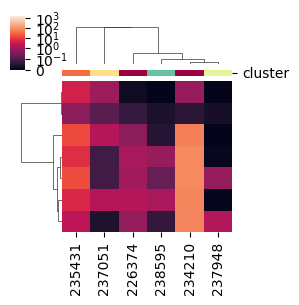

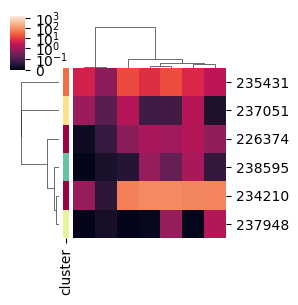

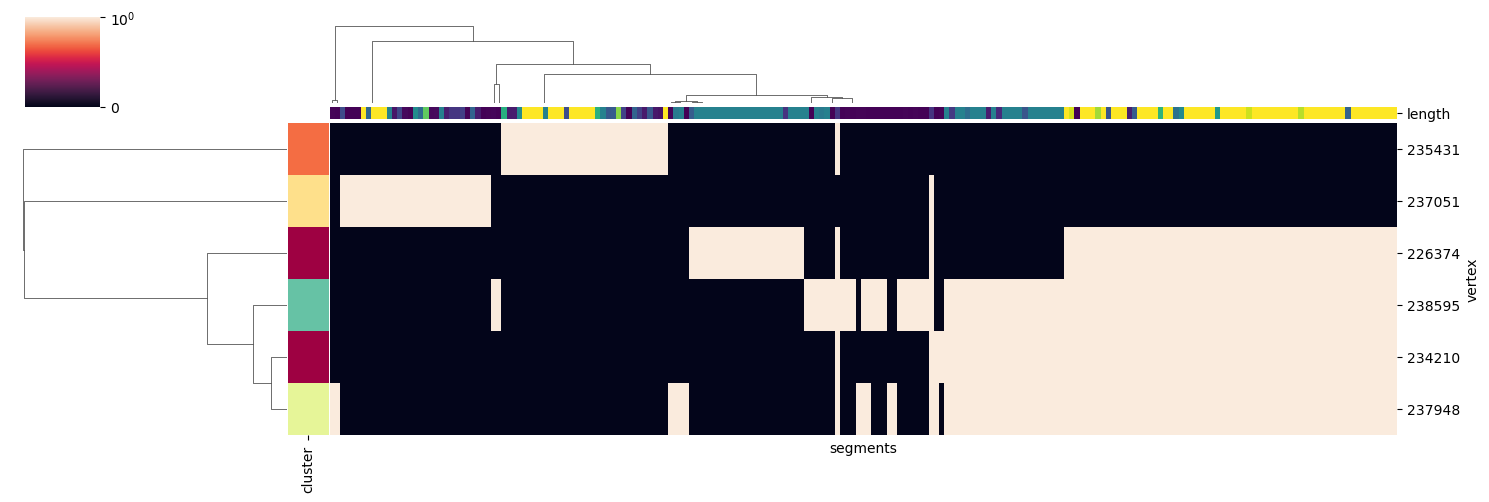

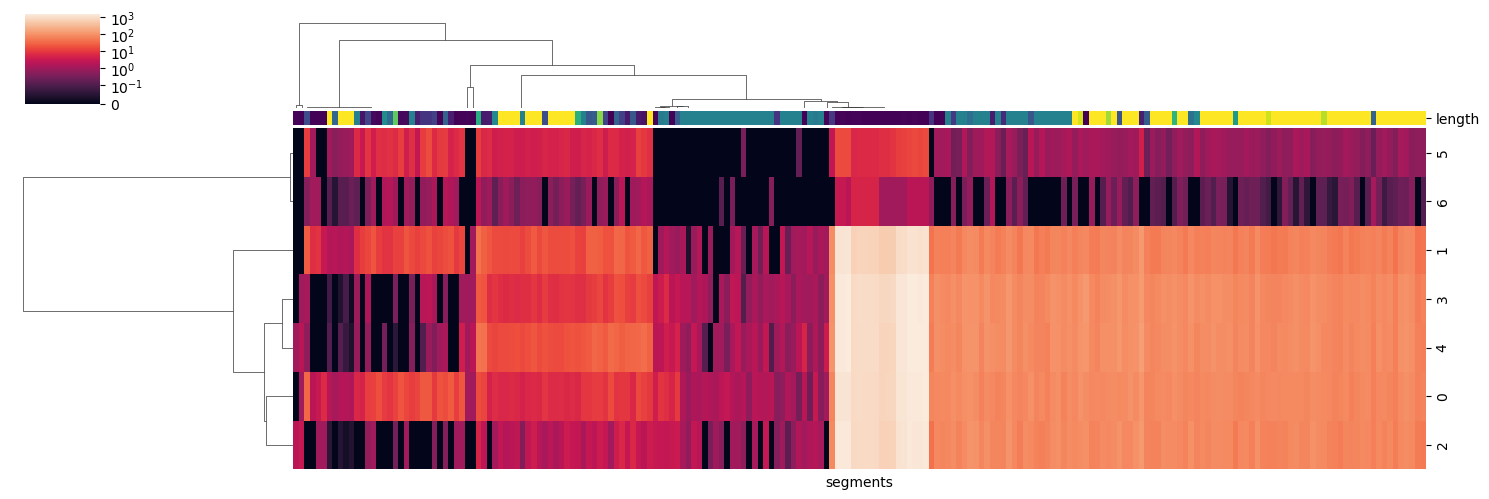

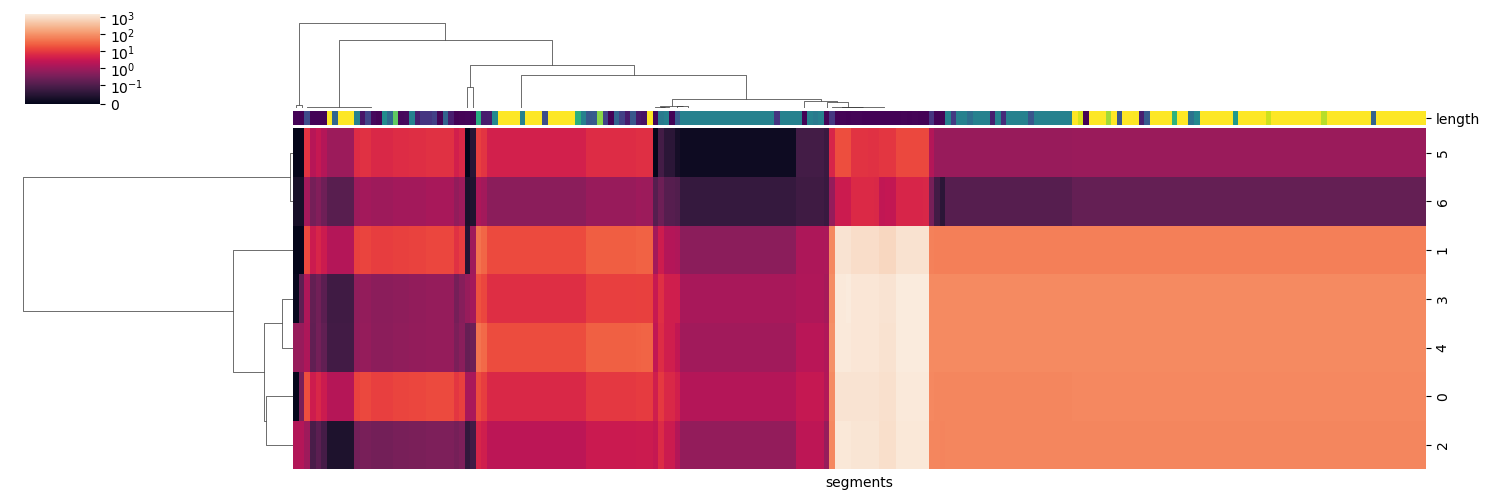

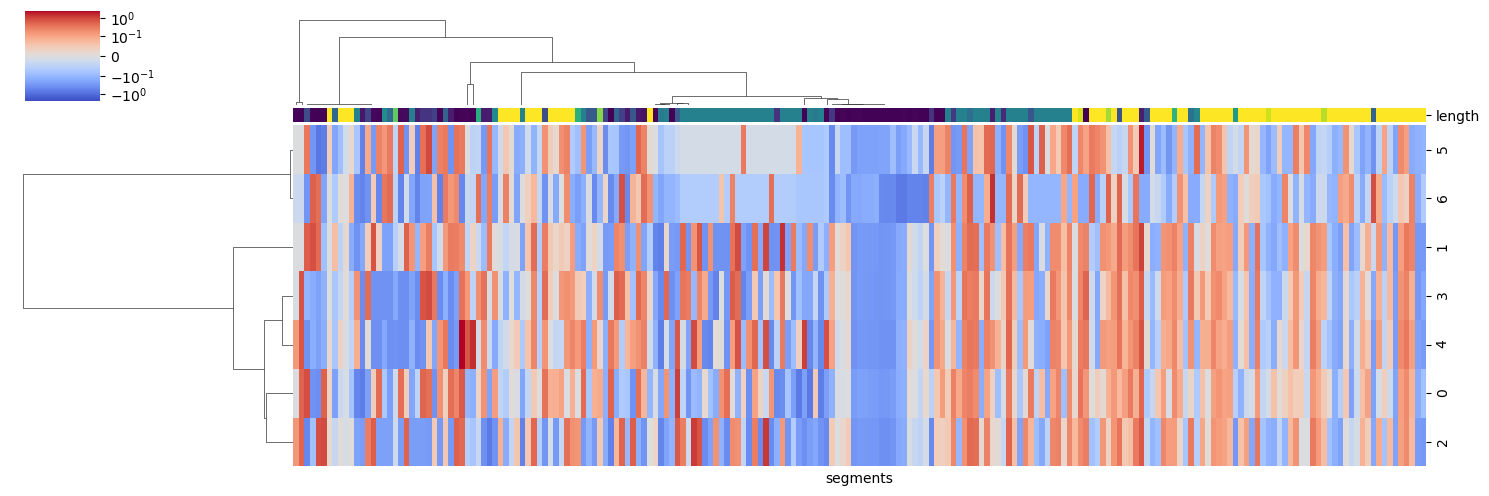

In [77]:
# # Select paths that share any vertices with a given path.
# focal_segments = list(set(final_results.loc[focal_path].segments))
# related_paths = list(sz.results.iter_find_vertices_with_any_segment(final_graph, final_results.loc[focal_path].segments))

# # # Select paths going through a single segment
# # focal_segments = ['1668157+'] # Single focal segment
# # related_paths = list(sz.results.iter_find_vertices_with_any_segment(final_graph, focal_segments))

# related_segments = list(set(chain(*final_results.loc[related_paths].segments)))
# print(len(related_paths), len(related_segments))


path_membership = (
    final_results.loc[related_paths]
    .segments.explode()
    .reset_index()
    .value_counts()
    .unstack(fill_value=0)
)
_obs_segment_depth = obs_segment_depth.loc[path_membership.columns].T
est_path_depth = vertex_depth.T[related_paths]
pred_unitig_depth = final_segment_depth.loc[path_membership.columns].T
resid_unitig_depth = _obs_segment_depth - pred_unitig_depth
relative_resid_unitig_depth = resid_unitig_depth / (pred_unitig_depth + 1)
_segment_length_colors = segment_length.loc[path_membership.columns].map(mpl.cm.viridis)

max_obs = _obs_segment_depth.max().max()
max_resid = np.abs(relative_resid_unitig_depth).max().max()


clust_palette = lib.plot.construct_ordered_palette(
    vertex_to_clust.loc[related_paths].values
)
clust_colors = vertex_to_clust.loc[related_paths].map(clust_palette)

# unitig_linkage = fastcluster.linkage(_obs_segment_depth.T, metric='euclidean', method='average')
unitig_linkage = fastcluster.linkage(
    pred_unitig_depth.T, metric="cosine", method="average"
)
path_linkage = fastcluster.linkage(path_membership, metric="cosine", method="average")
sample_linkage = fastcluster.linkage(
    _obs_segment_depth, metric="euclidean", method="average"
)

sns.clustermap(
    est_path_depth,
    row_linkage=sample_linkage,
    col_linkage=path_linkage,
    col_colors=clust_colors,
    yticklabels=0,
    xticklabels=1,
    figsize=(3, 3),
    norm=mpl.colors.SymLogNorm(1e-1, vmin=0, vmax=max_obs),
)
sns.clustermap(
    est_path_depth.T,
    col_linkage=sample_linkage,
    row_linkage=path_linkage,
    row_colors=clust_colors,
    xticklabels=0,
    yticklabels=1,
    figsize=(3, 3),
    norm=mpl.colors.SymLogNorm(1e-1, vmin=0, vmax=max_obs),
)
sns.clustermap(
    path_membership,
    row_linkage=path_linkage,
    col_linkage=unitig_linkage,
    row_colors=clust_colors,
    col_colors=_segment_length_colors,
    figsize=(15, 5),
    xticklabels=0,
    norm=mpl.colors.SymLogNorm(1, vmin=0),
)
sns.clustermap(
    _obs_segment_depth,
    row_linkage=sample_linkage,
    col_linkage=unitig_linkage,
    col_colors=_segment_length_colors,
    figsize=(15, 5),
    norm=mpl.colors.SymLogNorm(1e-1, vmin=0, vmax=max_obs),
    xticklabels=0,
)
sns.clustermap(
    pred_unitig_depth,
    row_linkage=sample_linkage,
    col_linkage=unitig_linkage,
    col_colors=_segment_length_colors,
    figsize=(15, 5),
    norm=mpl.colors.SymLogNorm(1e-1, vmin=0, vmax=max_obs),
    xticklabels=0,
)
sns.clustermap(
    relative_resid_unitig_depth,
    row_linkage=sample_linkage,
    col_linkage=unitig_linkage,
    col_colors=_segment_length_colors,
    figsize=(15, 5),
    norm=mpl.colors.SymLogNorm(1e-1, vmin=-max_resid, vmax=max_resid),
    cmap="coolwarm",
    xticklabels=0,
)

In [ ]:
_cross_correlation.loc[x_id].idxmax()

In [ ]:
path_order = [184977, 210689, 187913]
_palette = {184977: "dodgerblue", 210689: "limegreen", 187913: "hotpink"}
_rename_strain = {
    "Veillonella-sp-3-1-44": "Veillonella parvulla Strain A",
    "Veillonella-sp-6-1-27": "Veillonella parvulla Strain B",
    "Veillonella-dispar-ATCC-17748": "Veillonella dispar",
}

x = normalized_vertex_depth.loc[path_order]
y = kraken_rabund.T
_cross_correlation = pd.DataFrame(
    1 - sp.spatial.distance.cdist(x, y, metric="cosine"), index=x.index, columns=y.index
)


fig, axs = lib.plot.subplots_grid(ncols=3, naxes=len(path_order), ax_height=3.5)

for x_id, ax in zip(x.index, axs.flatten()):
    y_id = _cross_correlation.loc[x_id].idxmax()
    print(y_id)

    max_val = max(x.loc[x_id].max(), y.loc[y_id].max())

    ax.scatter(x.loc[x_id], y.loc[y_id], s=15, color=_palette[x_id])
    ax.plot([0, 1], [0, 1], color="k", linestyle="--")
    ax.set_xscale("symlog", linthresh=1e-4, linscale=0.25)
    ax.set_yscale("symlog", linthresh=1e-4, linscale=0.25)
    ax.set_xlabel(f"Path {x_id}")
    ax.set_ylabel(_rename_strain[y_id], fontstyle="italic")
    ax.set_aspect(1)
    ax.set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e-0])
    # ax.annotate('{:0.01e}'.format(clust_meta.loc[clust_id].total_length), xy=(0.6, 0.3), xycoords='axes fraction')
    # cross_correlation.loc[strain_id].sort_values(ascending=False).head()

fig.tight_layout()

In [ ]:
clust_depth = (
    pd.read_table(
        f"data/group/{group}/r.proc.kmtricks-{kmtricks}.ggcat-{graph_type}.notips-2.smoothed-6.unzip-{deconv}.clust-{clust_params}.depth.tsv"
    )
    .rename(columns={"Unnamed: 0": "cluster"})
    .set_index("cluster")
    .T.rename(int)
)
sns.clustermap(
    clust_depth.rename(sample_idx_to_id).loc[
        :, idxwhere(clust_meta.total_length > 1_000_000)
    ],
    metric="cosine",
    norm=mpl.colors.SymLogNorm(1),
)

In [ ]:
clust_rabund = clust_depth.divide(marker_depth.sum(1), axis=0)

sns.clustermap(
    clust_rabund[idxwhere(clust_meta.total_length > 1_000_000)].rename(
        sample_idx_to_id
    ),
    norm=mpl.colors.SymLogNorm(1e-5),
    metric="cosine",
)

In [ ]:
x = kraken_rabund
y = clust_rabund[idxwhere(clust_meta.total_length > 2_000_000)].rename(sample_idx_to_id)

x, y = x.align(y, join="inner", axis="index")

cross_correlation = pd.DataFrame(
    1 - sp.spatial.distance.cdist(x.T, y.T, metric="cosine"),
    index=x.columns,
    columns=y.columns,
)

sns.clustermap(cross_correlation)

In [ ]:
_strain_id_list = kraken_rabund.columns

fig, axs = lib.plot.subplots_grid(ncols=5, naxes=len(_strain_id_list))

for strain_id, ax in zip(_strain_id_list, axs.flatten()):
    clust_id = cross_correlation.loc[strain_id].idxmax()

    max_val = max(x[strain_id].max(), y[clust_id].max())

    ax.scatter(x[strain_id], y[clust_id])
    ax.plot([0, max_val], [0, max_val])
    ax.set_xscale("symlog", linthresh=1e-5)
    ax.set_yscale("symlog", linthresh=1e-5)
    ax.set_xlabel(strain_id)
    ax.set_ylabel(f"bin {clust_id}")
    ax.set_aspect(1)
    ax.annotate(
        "{:0.01e}".format(clust_meta.loc[clust_id].total_length),
        xy=(0.6, 0.3),
        xycoords="axes fraction",
    )
    # cross_correlation.loc[strain_id].sort_values(ascending=False).head()

fig.tight_layout()

In [ ]:
strain_id = "Bacteroides-thetaiotaomicron-VPI-5482"

fig, ax = plt.subplots()

clust_id = cross_correlation.loc[strain_id].idxmax()

max_val = max(x[strain_id].max(), y[clust_id].max())

ax.scatter(x[strain_id], y[clust_id])
ax.plot([0, max_val], [0, max_val])
ax.set_xlabel(strain_id)
ax.set_ylabel(f"bin {clust_id}")
ax.annotate(
    "{:0.01e}".format(clust_meta.loc[clust_id].total_length),
    xy=(0.6, 0.3),
    xycoords="axes fraction",
)
# ax.set_xscale('symlog', linthresh=1e-5)
# ax.set_yscale('symlog', linthresh=1e-5)
ax.set_aspect(1)
# fig.tight_layout()
cross_correlation.loc[strain_id].sort_values(ascending=False).head()

In [ ]:
focal_clust = 20

focal_clusts = [
    focal_clust,
    # 2383,
    338,
    332,
]

clust_palette = lib.plot.construct_ordered_palette(focal_clusts, cm="tab20")

focal_clust_segments = idxwhere(segement_x_clust == focal_clust)

d = final_results.loc[idxwhere(vertex_to_clust.isin(focal_clusts))].sort_values(
    "length", ascending=False
)  # .head(20)

for clust in focal_clusts:
    color = clust_palette[clust]
    plt.scatter(
        "length",
        "total_depth",
        data=d.loc[idxwhere(vertex_to_clust == clust)],
        s=4,
        label=clust,
        color=color,
    )
plt.xscale("log")
plt.yscale("log")
plt.legend()

print(d.length.sum())
d.join(vertex_to_clust).sort_values("num_segments", ascending=False)

In [ ]:
_col_colors = d.length.pipe(np.log10).pipe(lambda x: mpl.cm.viridis(x / x.max()))
# _col_colors = d.index.to_series().map(vertex_to_clust).map(clust_palette)

sns.clustermap(
    vertex_depth.loc[d.index].T.rename(sample_idx_to_id),
    col_colors=_col_colors,
    metric="cosine",
    norm=mpl.colors.SymLogNorm(linthresh=1),
)

In [ ]:
cg = sns.clustermap(
    vertex_depth.loc[idxwhere(d.length > 1000)].T.rename(sample_idx_to_id),
    metric="cosine",
    norm=mpl.colors.SymLogNorm(linthresh=0.01),
    figsize=(6, 2.5),
    dendrogram_ratio=(0, 0.2),
    xticklabels=0,
    yticklabels=0,
)

cg.ax_cbar.set_visible(False)

In [ ]:
clust_neighborhood_segment_graph = sz.io.load_graph(
    f"data/group/{group}/r.proc.kmtricks-{kmtricks}.ggcat-{graph_type}.notips-2.smoothed-6.unzip-{deconv}.clust-{clust_params}.unassembled-c{focal_clust}-r100.notips-1-unpressed.sz"
)
sz.results.extract_vertex_data(clust_neighborhood_segment_graph).sort_values(
    "length", ascending=False
)  # .head(20)

In [ ]:
_graph = clust_neighborhood_segment_graph


sz.draw.update_xypositions(_graph)
print("Done with layout.")

# Color by depth
vertex_color = _graph.new_vertex_property(
    "float", vals=np.log(sz.results.total_depth_property(_graph).a + 1)
)

# Highlight vertices in the cluster itself.
_vertices = list(
    sz.results.iter_find_vertices_with_any_segment(_graph, focal_clust_segments)
)
print(len(_vertices))
in_path = _graph.new_vertex_property("bool", val=False)
in_path.a[_vertices] = 1

outpath = f"{fig_dir}/clust-{focal_clust}.pdf"
sz.draw.draw_graph(
    _graph,
    # vertex_text=_graph.vp['length'],
    vertex_text=_graph.vp["sequence"],
    vertex_halo=in_path,
    # vertex_font_size=5,
    vertex_fill_color=vertex_color,
    # edge_pen_width=10,
    output=outpath,
    vcmap=(mpl.cm.magma, 1),
    output_size=(1000, 1000),
)
print(outpath)

In [ ]:
segment_x_cluster = pd.read_table(
    f"data/group/{group}/r.proc.kmtricks-{kmtricks}.ggcat-{graph_type}.notips-2.smoothed-6.unzip-{deconv}.clust-{clust_params}.segment.tsv"
)

In [ ]:
%%time
radius = 10

focal_clusts = [
    20,
    # 2383,
    338,
    332,
]

# Select segments
_segment_list = list(
    segment_x_cluster[lambda x: x.cluster.isin(focal_clusts)]
    .segment.drop_duplicates()
    .values
)

# Select vertices
_vertex_list = list(
    sz.results.iter_find_vertices_with_any_segment(unpressed_graph, _segment_list)
)
# Find neighborhood
_distance_from_focal = sz.topology.get_shortest_distance_to_any_vertex(
    unpressed_graph, _vertex_list, unpressed_graph.vp["length"]
)
_vertex_mask = unpressed_graph.new_vertex_property(
    "bool", vals=_distance_from_focal.a <= radius
)
_neighborhood_vertex_list = idxwhere(
    pd.DataFrame(
        unpressed_graph.get_vertices(vprops=[_vertex_mask]), columns=["vertex", "mask"]
    ).set_index("vertex")["mask"]
    == 1
)
_graph0 = gt.Graph(gt.GraphView(unpressed_graph, vfilt=_vertex_mask), prune=True)
print(_graph0)

# Layout graph
gt.seed_rng(1)
np.random.seed(2)
sz.draw.update_xypositions(
    _graph0, layout=gt.draw.random_layout
)  # NOTE: This allows for reproducible layouts.
print("Done with Step 1.")
sz.draw.update_xypositions(
    _graph0,
    layout=gt.draw.sfdp_layout,
    # p=1.4,
    # K=1,
)
print("Done with layout!")

In [ ]:
# _palette = {332: 'fuchsia', 2383: 'silver', 20: 'lime', 338: 'cyan'}
_palette = {332: "hotpink", 2383: "silver", 20: "limegreen", 338: "dodgerblue"}

In [ ]:
# Decorate vertices
_results = sz.results.extract_vertex_data(_graph0)
_segment_to_vertex = (
    _results.segments.str[0]
    .reset_index()
    .set_index("segments")
    .vertex.rename_axis(index="segment")
)

clust_membership = (
    final_results[lambda x: x.clust.isin(focal_clusts)]
    .groupby("clust")
    .apply(lambda x: x.segments.explode().drop_duplicates(), include_groups=False)
    .rename("segment")
    .reset_index()
    .set_index(["clust", "segment"])
    .assign(tally=1)
    .tally.unstack(fill_value=0)
    .T.rename(_segment_to_vertex)
    .reindex(_graph0.get_vertices(), fill_value=0)
    # .sort_index()
)

In [ ]:
# num_clusts = 3
# _clusts1 = focal_clusts[:num_clusts]

_clust_order = [
    332,
    20,
    # 2383,
    338,
]

_clusts1 = _clust_order
_graph1 = _graph0.copy()

# # Select vertices in bin.
# _clusts1 = _clust_order[:i + 1]
# _mask1 = sz.results.extract_vertex_data(_graph0).segments.str[0].isin(segment_x_cluster[lambda x: x.cluster.isin(_clusts1)].segment)
# print(_mask1.mean())
# _graph1 = gt.GraphView(_graph0, vfilt=_mask1)

# # Decorate vertices
# _clust_mem = clust_membership[_mask1][_clusts1]
# _clust_frac1 = _clust_mem.divide(_clust_mem.sum(axis=1), axis=0)
# _graph1.vp['clust_frac'] = _graph1.new_vertex_property('vector<float>', vals=_clust_frac1.sort_index().values)

# Decorate vertices
_color_subset = (
    sz.results.extract_vertex_data(_graph0)
    .segments.str[0]
    .isin(segment_x_cluster[lambda x: x.cluster.isin(_clusts1)].segment)
)
_clust_mem = clust_membership[_color_subset][_clusts1]
_clust_frac1 = _clust_mem.divide(_clust_mem.sum(axis=1), axis=0).reindex(
    _graph1.get_vertices(), fill_value=0
)
_clust_frac_vprop = _graph1.new_vertex_property(
    "vector<float>", vals=_clust_frac1.sort_index().values
)

outpath = f"{fig_dir}/Veill-multibin.all.png"
sz.draw.draw_graph(
    _graph1,
    output=outpath,
    vertex_text="",
    # vertex_color='k',
    vertex_size=30,
    vertex_shape="pie",
    vertex_pie_fractions=_clust_frac_vprop,
    vertex_pie_colors=[_palette[c] for c in _clusts1],
    output_size=(2000, 2000),
)
print(outpath)

In [ ]:
# num_clusts = 3
# _clusts1 = focal_clusts[:num_clusts]

_clust_order = [
    332,
    20,
    # 2383,
    338,
]

for c in _clust_order:
    _clusts1 = [c]
    _graph1 = _graph0.copy()

    # # Select vertices in bin.
    # _clusts1 = _clust_order[:i + 1]
    # _mask1 = sz.results.extract_vertex_data(_graph0).segments.str[0].isin(segment_x_cluster[lambda x: x.cluster.isin(_clusts1)].segment)
    # print(_mask1.mean())
    # _graph1 = gt.GraphView(_graph0, vfilt=_mask1)

    # # Decorate vertices
    # _clust_mem = clust_membership[_mask1][_clusts1]
    # _clust_frac1 = _clust_mem.divide(_clust_mem.sum(axis=1), axis=0)
    # _graph1.vp['clust_frac'] = _graph1.new_vertex_property('vector<float>', vals=_clust_frac1.sort_index().values)

    # Decorate vertices
    _color_subset = (
        sz.results.extract_vertex_data(_graph0)
        .segments.str[0]
        .isin(segment_x_cluster[lambda x: x.cluster.isin(_clusts1)].segment)
    )
    _clust_mem = clust_membership[_color_subset][_clusts1]
    _clust_frac1 = _clust_mem.divide(_clust_mem.sum(axis=1), axis=0).reindex(
        _graph1.get_vertices(), fill_value=0
    )
    _clust_frac_vprop = _graph1.new_vertex_property(
        "vector<float>", vals=_clust_frac1.sort_index().values
    )

    outpath = f"{fig_dir}/Veill-multibin.{c}.png"
    sz.draw.draw_graph(
        _graph1,
        output=outpath,
        vertex_text="",
        # vertex_color='k',
        vertex_size=30,
        vertex_shape="pie",
        vertex_pie_fractions=_clust_frac_vprop,
        vertex_pie_colors=[_palette[c] for c in _clusts1],
        output_size=(2000, 2000),
    )
    print(outpath)

In [ ]:
shared_segments = pd.read_table(
    f"data/group/{group}/r.proc.kmtricks-{kmtricks}.ggcat-{graph_type}.notips-2.smoothed-6.unzip-{deconv}.clust-{clust_params}.shared.tsv"
)  # .set_index(['clusterA', 'clusterB']).num_shared_segments.unstack(fill_value=0).reindex(index=clust_meta.index, columns=clust_meta.index, fill_value=0)
shared_segments.sort_values(
    "num_shared_segments", ascending=False
)  # [lambda x: x.clusterA.isin([212]) | x.clusterB.isin([212])].head(10)
# shared_segments.values[:,:] += shared_segments.values.T
# shared_segments.max().sort_values()

In [ ]:
shared_segments[lambda x: x.clusterA == 98].sort_values(
    "num_shared_segments", ascending=False
).head()

In [ ]:
clust_meta2 = pd.read_table(
    f"data/group/{group}/r.proc.kmtricks-{kmtricks}.ggcat-{graph_type}.notips-2.clust-{clust_params}.meta.tsv",
    index_col="cluster",
)
clust_depth2 = (
    pd.read_table(
        f"data/group/{group}/r.proc.kmtricks-{kmtricks}.ggcat-{graph_type}.notips-2.clust-{clust_params}.depth.tsv"
    )
    .rename(columns={"Unnamed: 0": "cluster"})
    .set_index("cluster")
    .T.rename(int)
)

clust_meta2.sort_values("total_length", ascending=False).head(10)

In [ ]:
vertex_depth2 = sz.results.depth_table(
    notips_unsmoothed_graph, notips_unsmoothed_graph.get_vertices()
).T

In [ ]:
# Normalize by rpoB depth
marker_genes2 = pd.read_table(
    f"data/group/{group}/r.proc.kmtricks-{kmtricks}.ggcat-{graph_type}.notips-2.cds.tran.hmmer-{marker_model}-ga.tsv",
    names=["orf", "gene_name", "bitscore"],
).assign(vertex=lambda x: x.orf.str.split("_").str[0].astype(int))
_marker_gene_vertex_list = list(set(marker_genes2.vertex))
marker_depth2 = vertex_depth2.loc[_marker_gene_vertex_list].T

In [ ]:
clust_rabund2 = clust_depth2.divide(marker_depth2.sum(1), axis=0)

In [ ]:
x = kraken_rabund
y = clust_rabund2[idxwhere(clust_meta2.total_length > 2_000_000)].rename(
    sample_idx_to_id
)

x, y = x.align(y, join="inner", axis="index")

cross_correlation2 = pd.DataFrame(
    1 - sp.spatial.distance.cdist(x.T, y.T, metric="cosine"),
    index=x.columns,
    columns=y.columns,
)

sns.clustermap(cross_correlation2)

In [ ]:
x = kraken_rabund
y = clust_rabund2[idxwhere(clust_meta2.total_length > 2_000_000)].rename(
    sample_idx_to_id
)

x, y = x.align(y, join="inner", axis="index")

_strain_id_list = kraken_rabund.columns
fig, axs = lib.plot.subplots_grid(ncols=5, naxes=len(_strain_id_list))
for strain_id, ax in zip(_strain_id_list, axs.flatten()):
    clust_id = cross_correlation2.loc[strain_id].idxmax()

    max_val = max(x[strain_id].max(), y[clust_id].max())

    ax.scatter(x[strain_id], y[clust_id])
    ax.plot([0, max_val], [0, max_val])
    ax.set_xlabel(strain_id)
    ax.set_ylabel(f"bin {clust_id}")
    ax.set_aspect(1)
    ax.annotate(
        "{:0.01e}".format(clust_meta2.loc[clust_id].total_length),
        xy=(0.6, 0.3),
        xycoords="axes fraction",
    )
    # cross_correlation.loc[strain_id].sort_values(ascending=False).head()

fig.tight_layout()

In [ ]:
vertex_to_clust.loc[marker_gene_vertex_list].value_counts().head(20)